# Previsão de Votação de Deputados Federais

Este documento tem objetivo de prever a quantidade de votos que os deputados tiveram em eleições passadas, utilizando modelos preditivos de regressão. 
Os passos seguidos neste notebook foram inspirados em um ja existente, que pode ser encontrado [neste link](https://www.kaggle.com/apapiu/regularized-linear-models)

Primeiramente vamos importar os dados:

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn import preprocessing

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
data = pd.read_csv("data/eleicoes_2006_a_2010.csv")

In [3]:
pd.set_option('display.max_columns', 500)
data.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,1300.0,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,201.0,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,1150.0,1101.12,750.0,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


## Ajuste dos dados
Vamos agora separar os dados de treino e teste, onde 2006 serão os de treino e 2010 os de teste.

Como podemos perceber, algumas variáveis não são importantes para a precisão, como o ano, visto que temos apenas 2006, o sequencial_candidato, o nome e o cargo, visto que é apenas deputado federal. Com isso, removeremos estas variáveis.

In [4]:
train = data[data.ano == 2006]
test = data[data.ano == 2010]

train = train.drop(["ano", "sequencial_candidato", "nome", "cargo"], axis=1)
test = test.drop(["ano", "sequencial_candidato", "nome", "cargo"], axis=1)

Vejamos as distribuições das variáveis numéricas, para verificar se são enviesadas:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68a7caf690>,
      dtype=object)

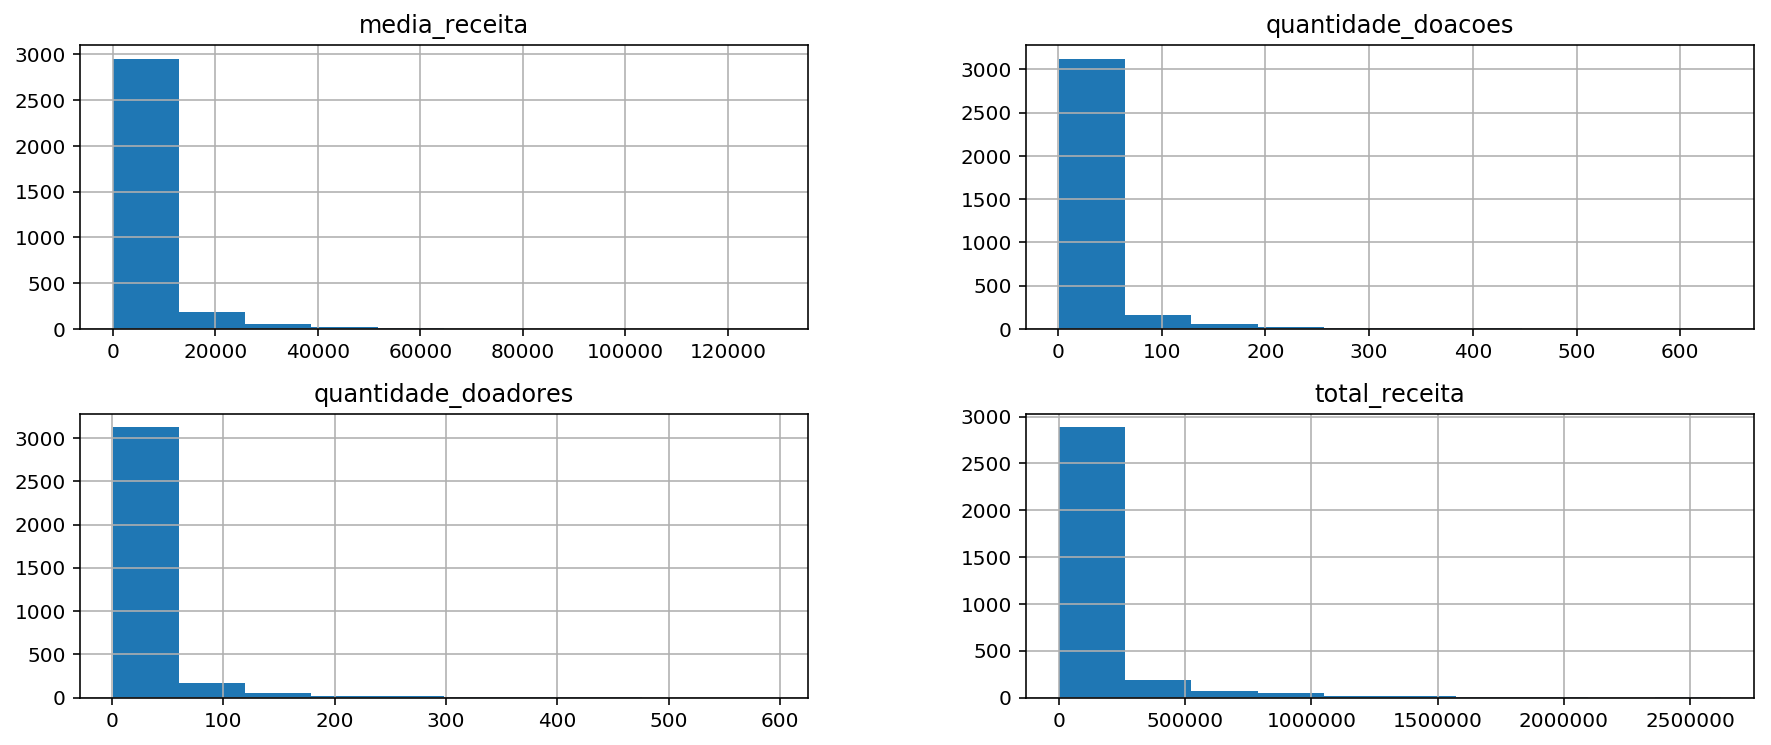

In [5]:
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)
train[["quantidade_doacoes", "quantidade_doadores", "total_receita", "media_receita"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68a5856190>,
      dtype=object)

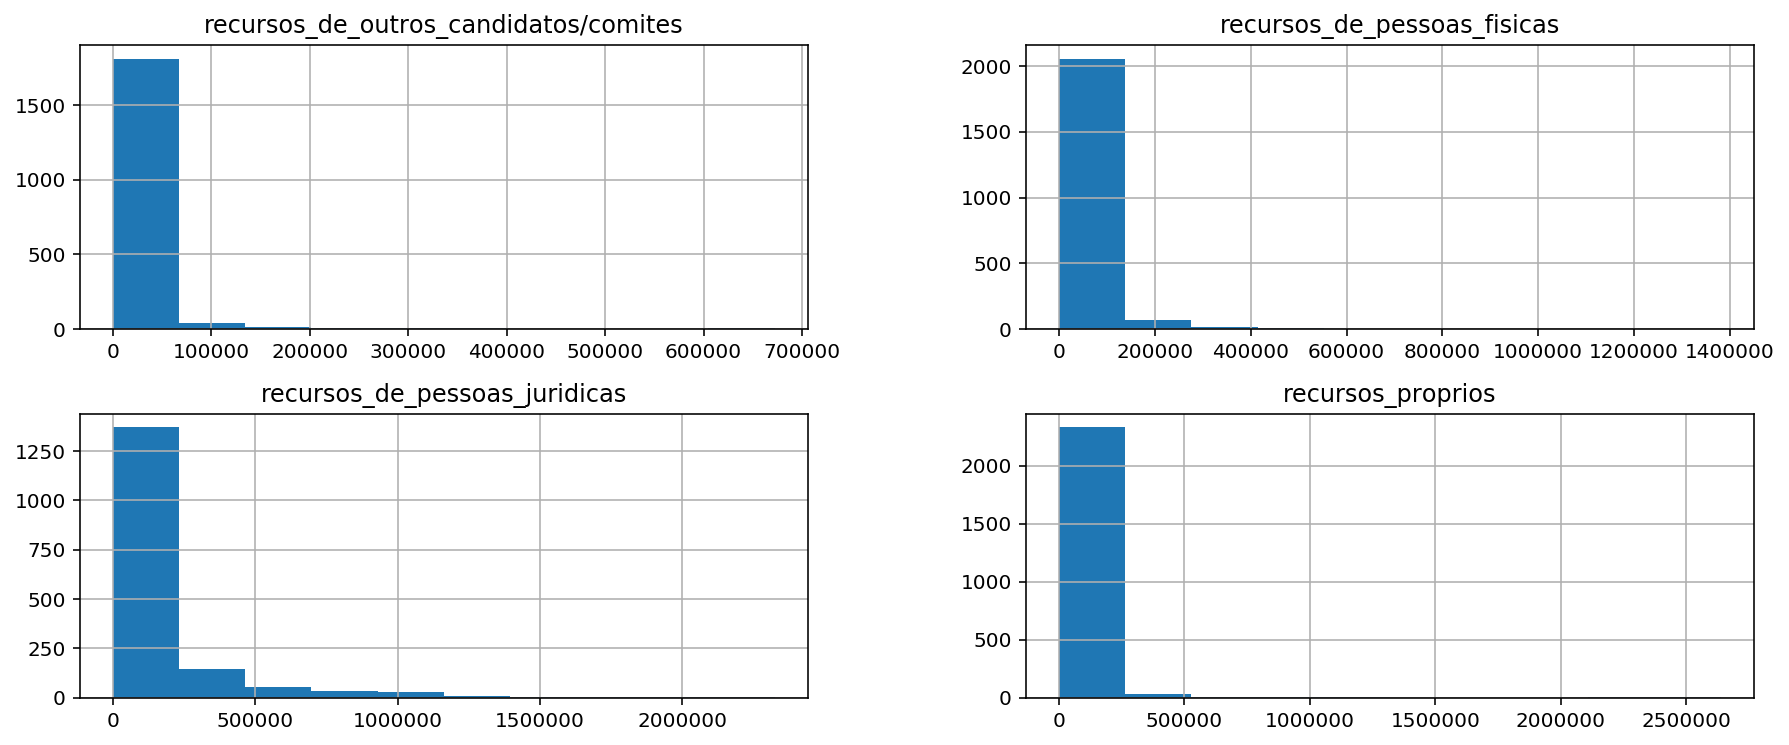

In [6]:
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)
train[["recursos_de_outros_candidatos/comites", "recursos_de_pessoas_fisicas", "recursos_de_pessoas_juridicas", "recursos_proprios"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68a596edd0>,
      dtype=object)

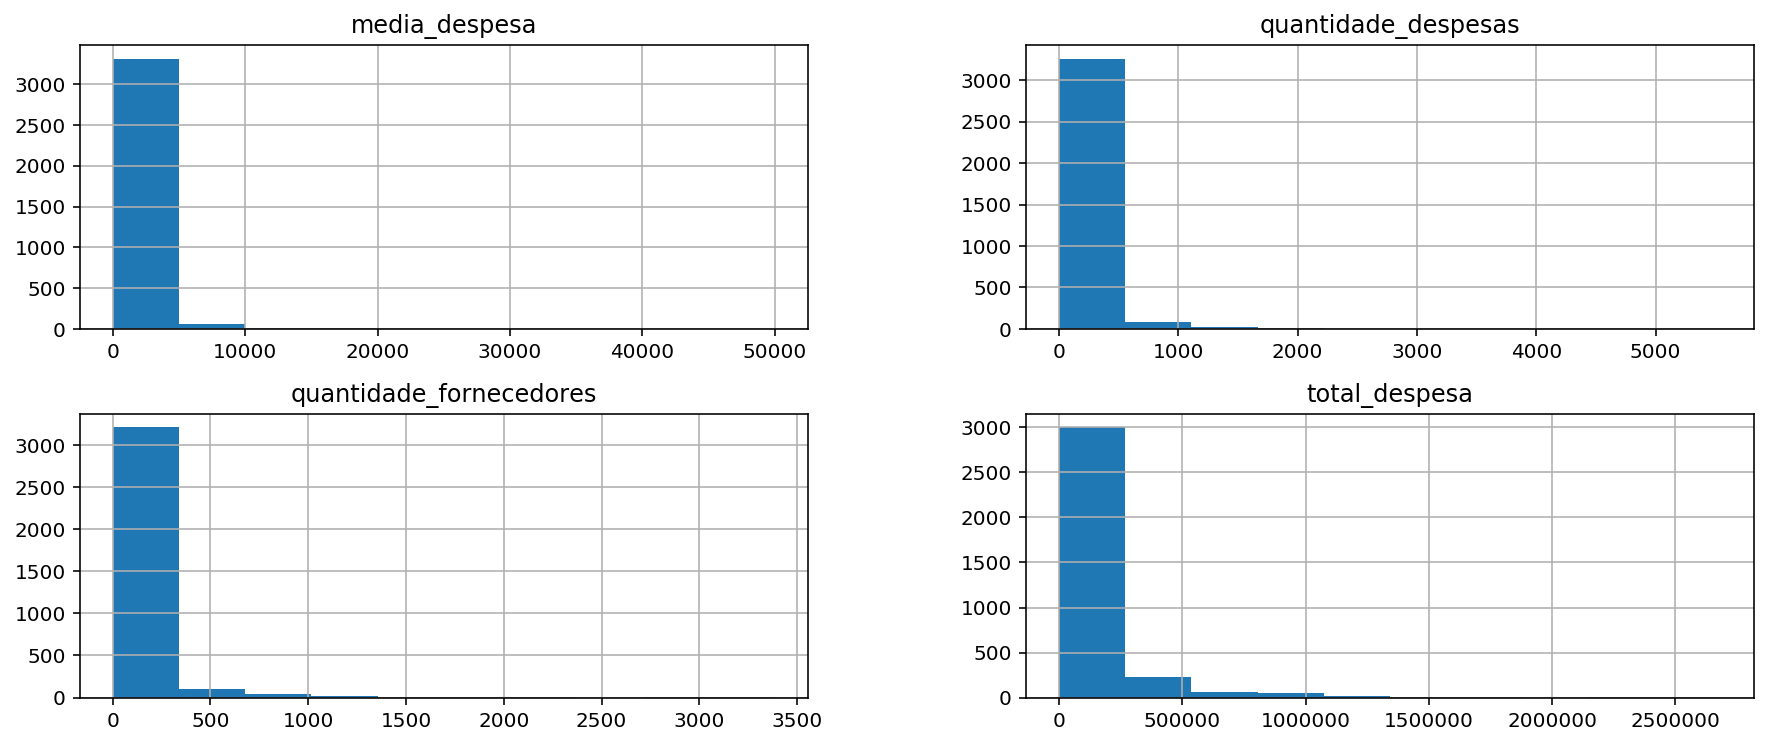

In [7]:
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)
train[["quantidade_despesas", "quantidade_fornecedores", "total_despesa", "media_despesa"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68a5647d90>]],
      dtype=object)

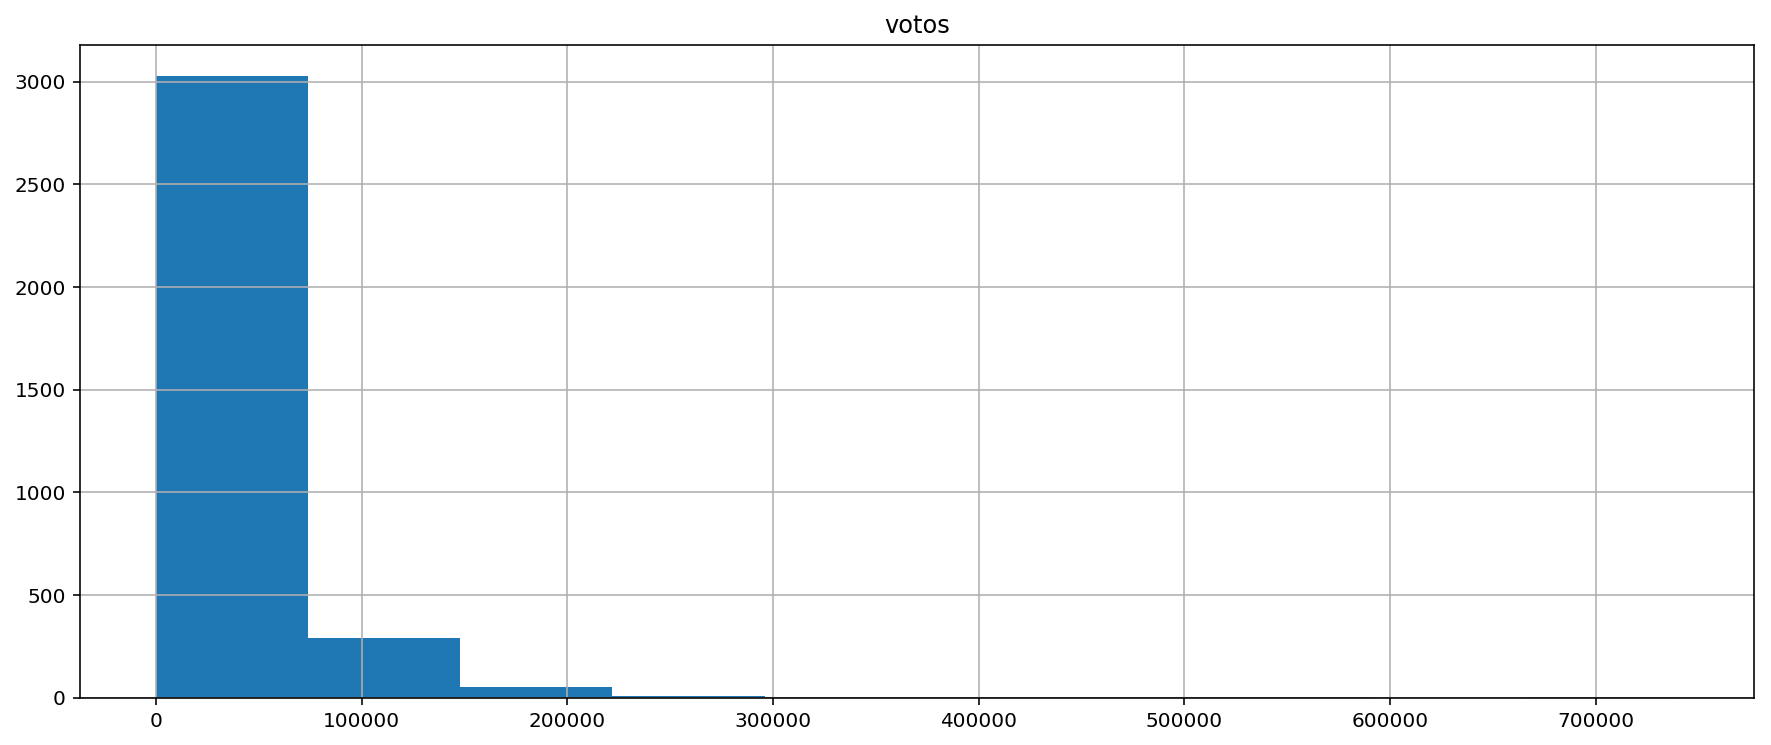

In [8]:
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)
train[["votos"]].hist()

Podemos perceber que todas as variáveis numéricas estão enviesadas à direita, logo aplicaremos a função log em cima 
das mesmas:

In [9]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
train[numeric_feats] = np.log1p(train[numeric_feats])
test[numeric_feats] = np.log1p(test[numeric_feats])

Vamos também remover os valores vazios, substituindo-os pela média da coluna:

In [10]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

Agora vamos normalizar as variáveis numéricas para ficar entre 0 e 1, excluindo a variável alvo:

In [11]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
numeric_feats = numeric_feats.drop("votos")
non_numeric_feats = train.dtypes[train.dtypes == "object"].index

min_max_scaler = preprocessing.MinMaxScaler()
train_normalized = min_max_scaler.fit_transform(train[numeric_feats])
test_normalized = min_max_scaler.fit_transform(test[numeric_feats])

train_normalized = pd.DataFrame(train_normalized, columns=train[numeric_feats].columns)
test_normalized = pd.DataFrame(test_normalized, columns=test[numeric_feats].columns)

train_normalized = train_normalized.assign(votos = train["votos"].values)
test_normalized = test_normalized.assign(votos = test["votos"].values)

train_normalized = pd.concat([train_normalized, train[non_numeric_feats].reset_index()], axis = 1, sort = False)
test_normalized = pd.concat([test_normalized, test[non_numeric_feats].reset_index()], axis = 1, sort = False)

train = train_normalized
test = test_normalized

Vamos agora transformar as variáveis categóricas para variáveis dummies, para que a regressão funcione corretamente:

In [12]:
transformed_data = pd.concat([train, test], keys=["train", "test"])
train = pd.get_dummies(transformed_data).loc["train"]
test = pd.get_dummies(transformed_data).loc["test"]

In [13]:
X_train = train.drop('votos', axis=1)
X_test = test
y = train.votos

## Modelagem
Agora vamos utilizar regularização tanto com o Lasso, quanto com o Ridge, utilizando validação cruzada para tunar os parâmetros.

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()

### Ridge

In [15]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

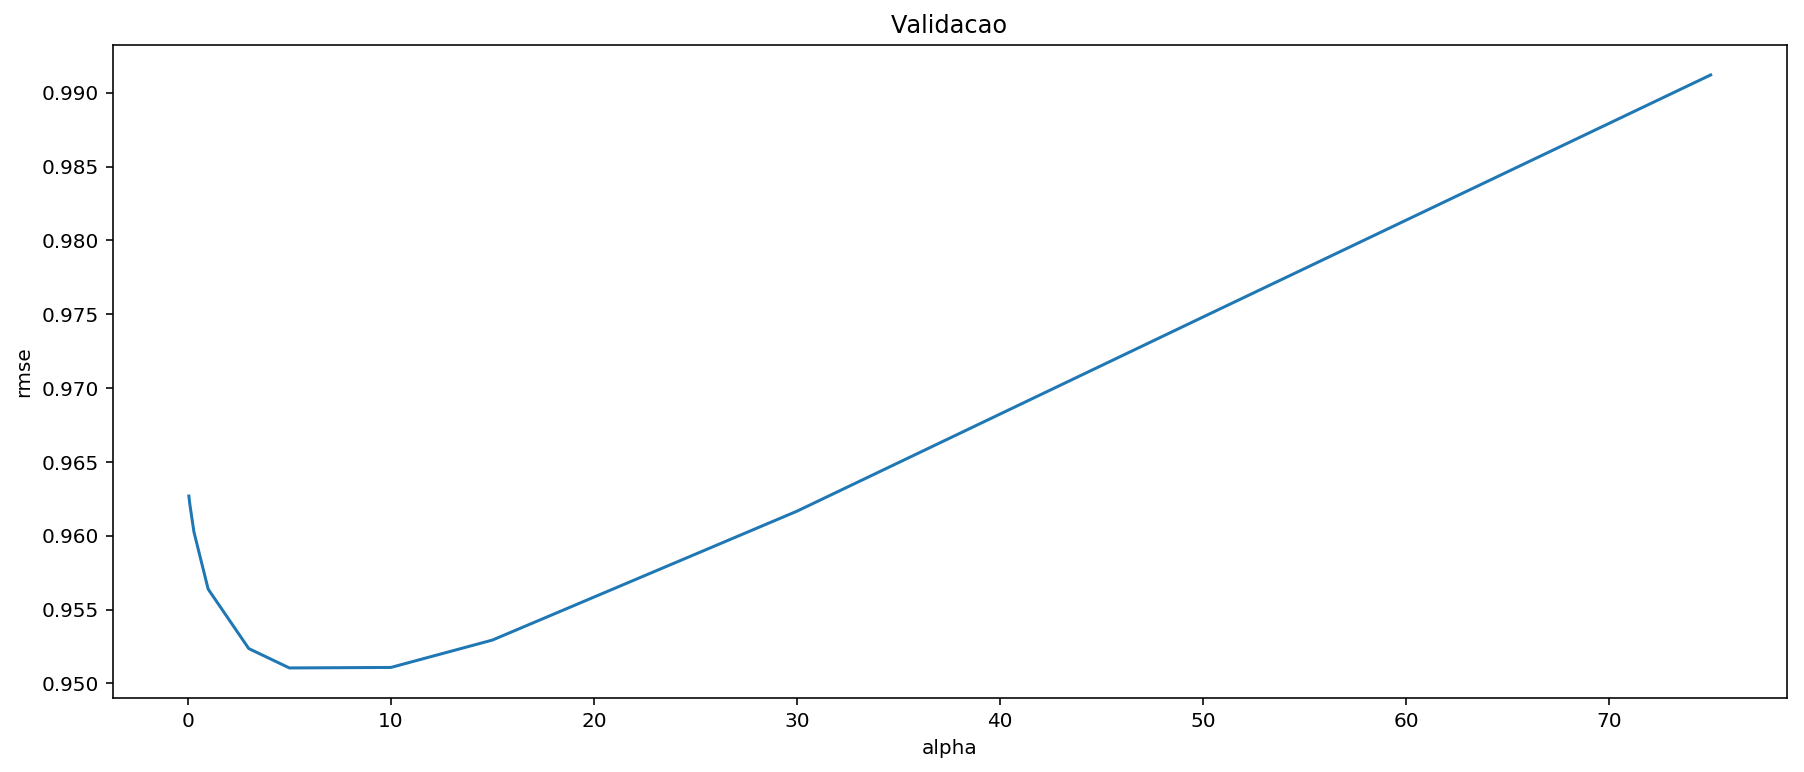

In [16]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validacao")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [17]:
cv_ridge.min()

0.9510489498268331

Vemos que o para a regressão ridge, o alpha escolhido como hiperparâmetro que obtém menor RMSE é alpha = 5, com RMSE de aproximadamente 0.9510.

Vejamos agora os resíduos para o modelo ridge:

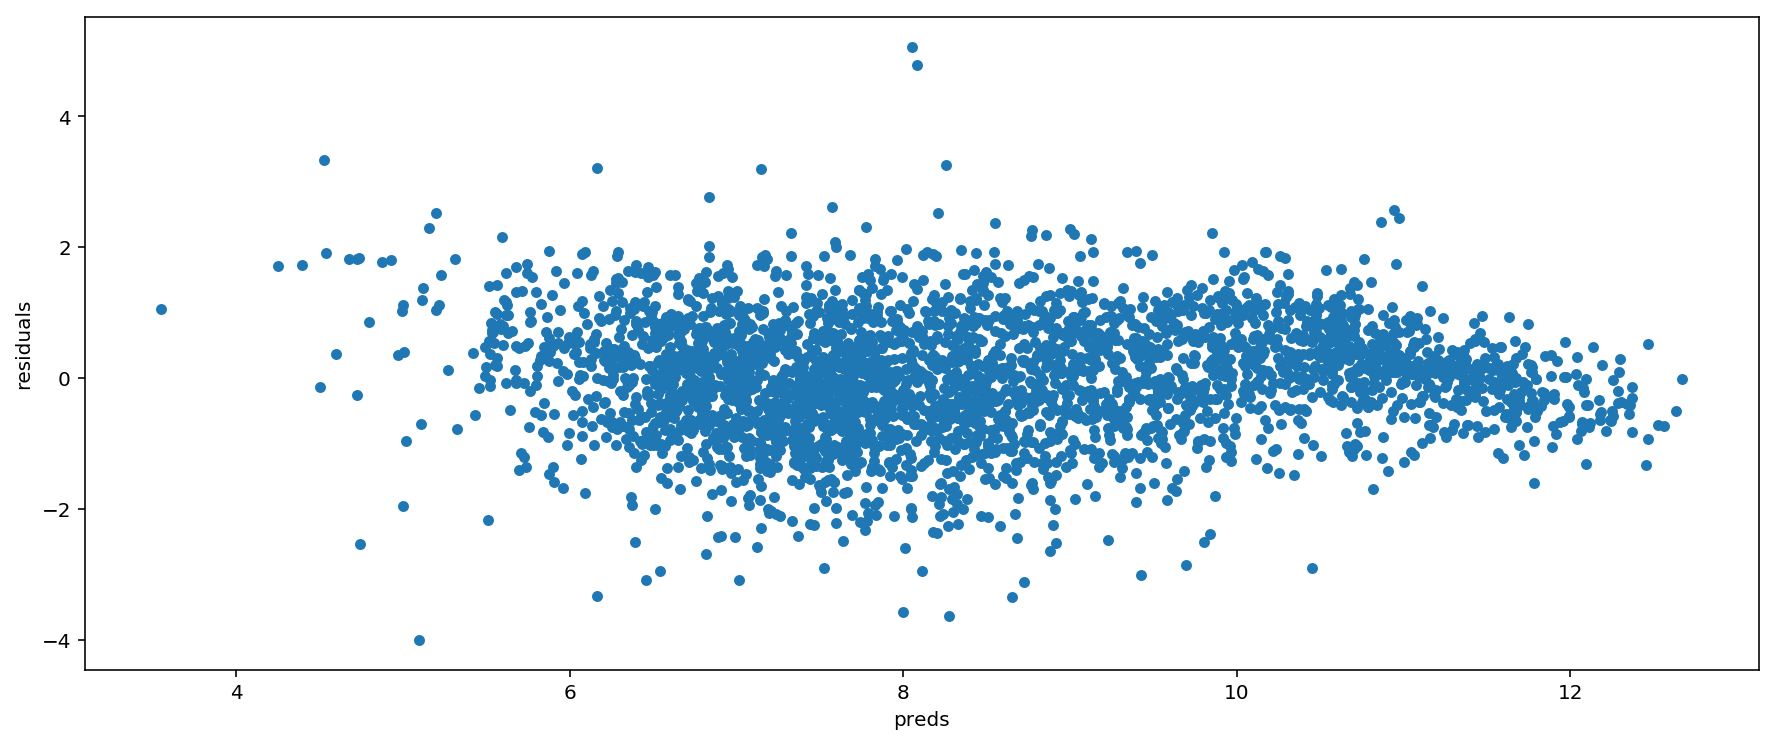

In [18]:
ridge = Ridge(alpha=5.0)
model_ridge = ridge.fit(X_train, y)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Os resíduos não parecem ter nenhum padrão.

### Lasso
Vejamos agora o comportamento com o modelo lasso:

In [19]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0005]).fit(X_train, y)

In [20]:
rmse_cv(model_lasso).mean()

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.9513136060841362

Vemos que o lasso obteve RMSE ligeiramente maior que o ridge, mas como ele faz seleção de features, vamos utilizá-lo para verificar a importância das variáveis.

In [21]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso selecionou " + str(sum(coef != 0)) + " variáveis e eliminou outras " +  str(sum(coef == 0)) + " variáveis.")

Lasso selecionou 101 variáveis e eliminou outras 159 variáveis.


In [22]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coeficientes no modelo lasso')

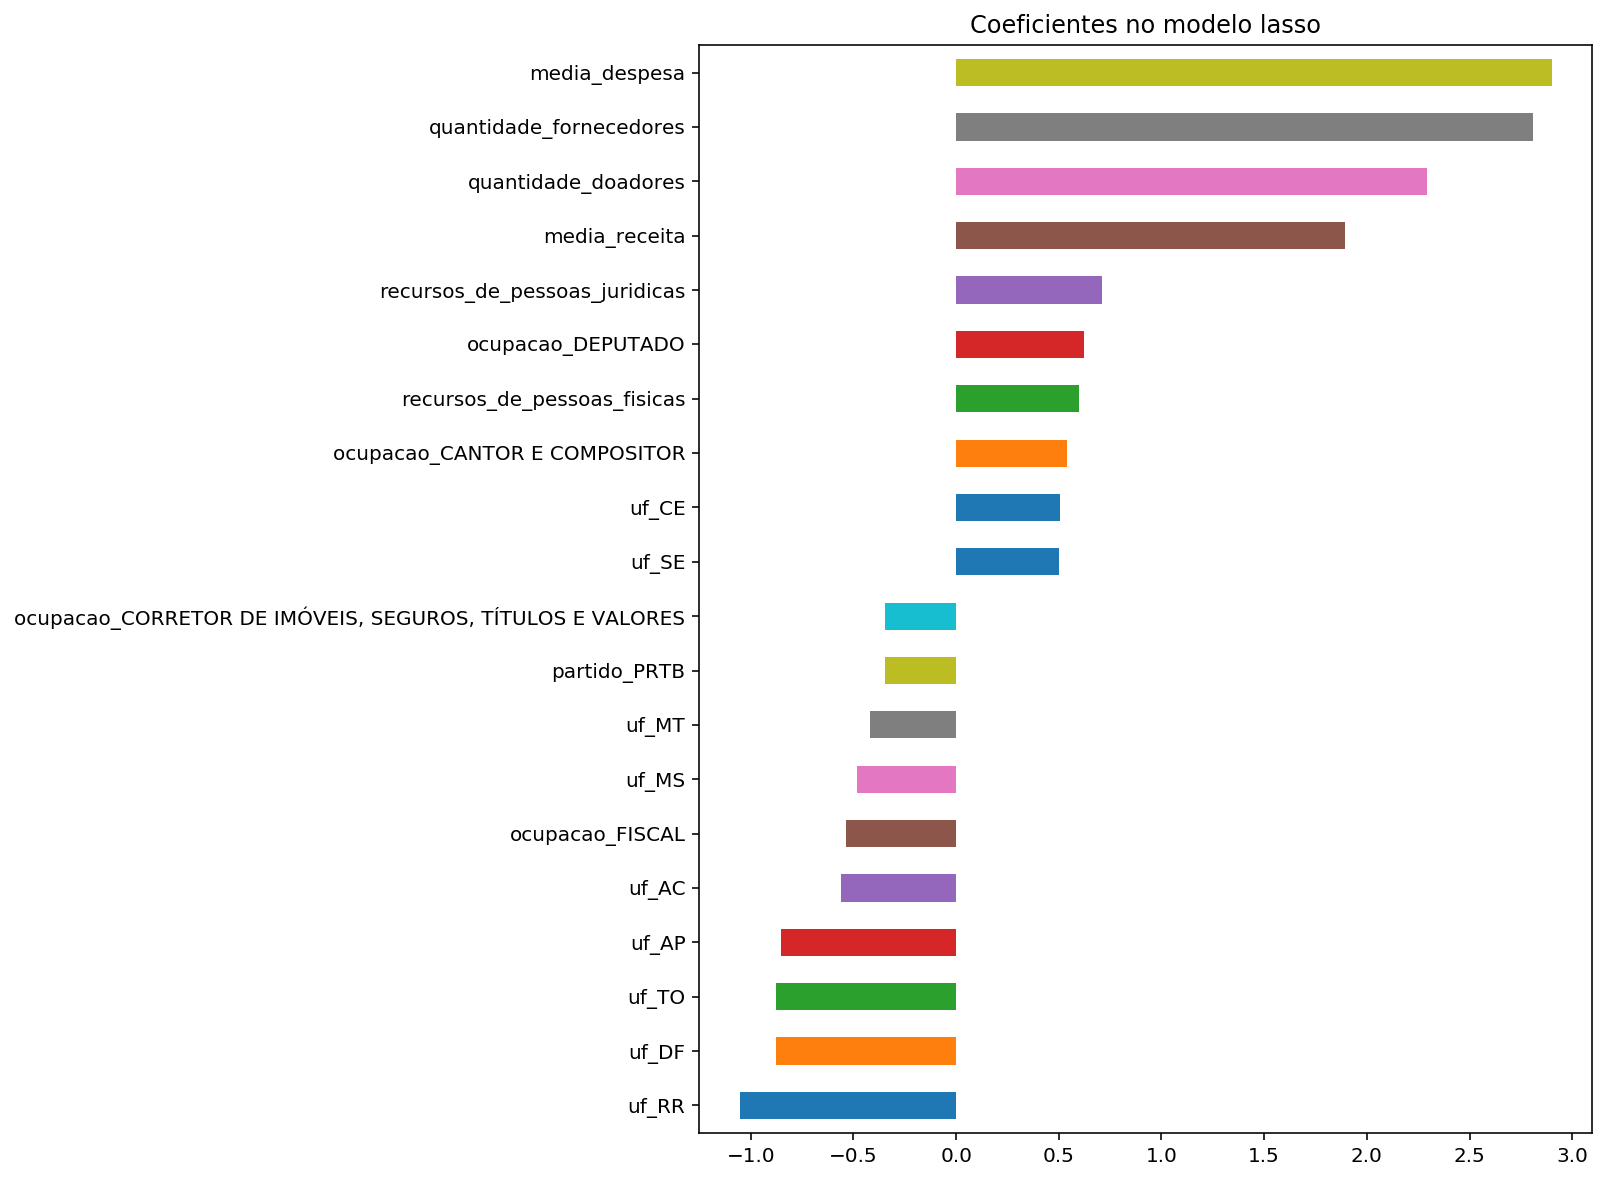

In [23]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coeficientes no modelo lasso")

Vemos que o modelo esta utilizando a média de despesa como a variável mais importante para prever sua quantidade de votos, depois a quantidade de fornecedores e em seguida quantidade de doadores e receita média.

Vejamos agora os resíduos:

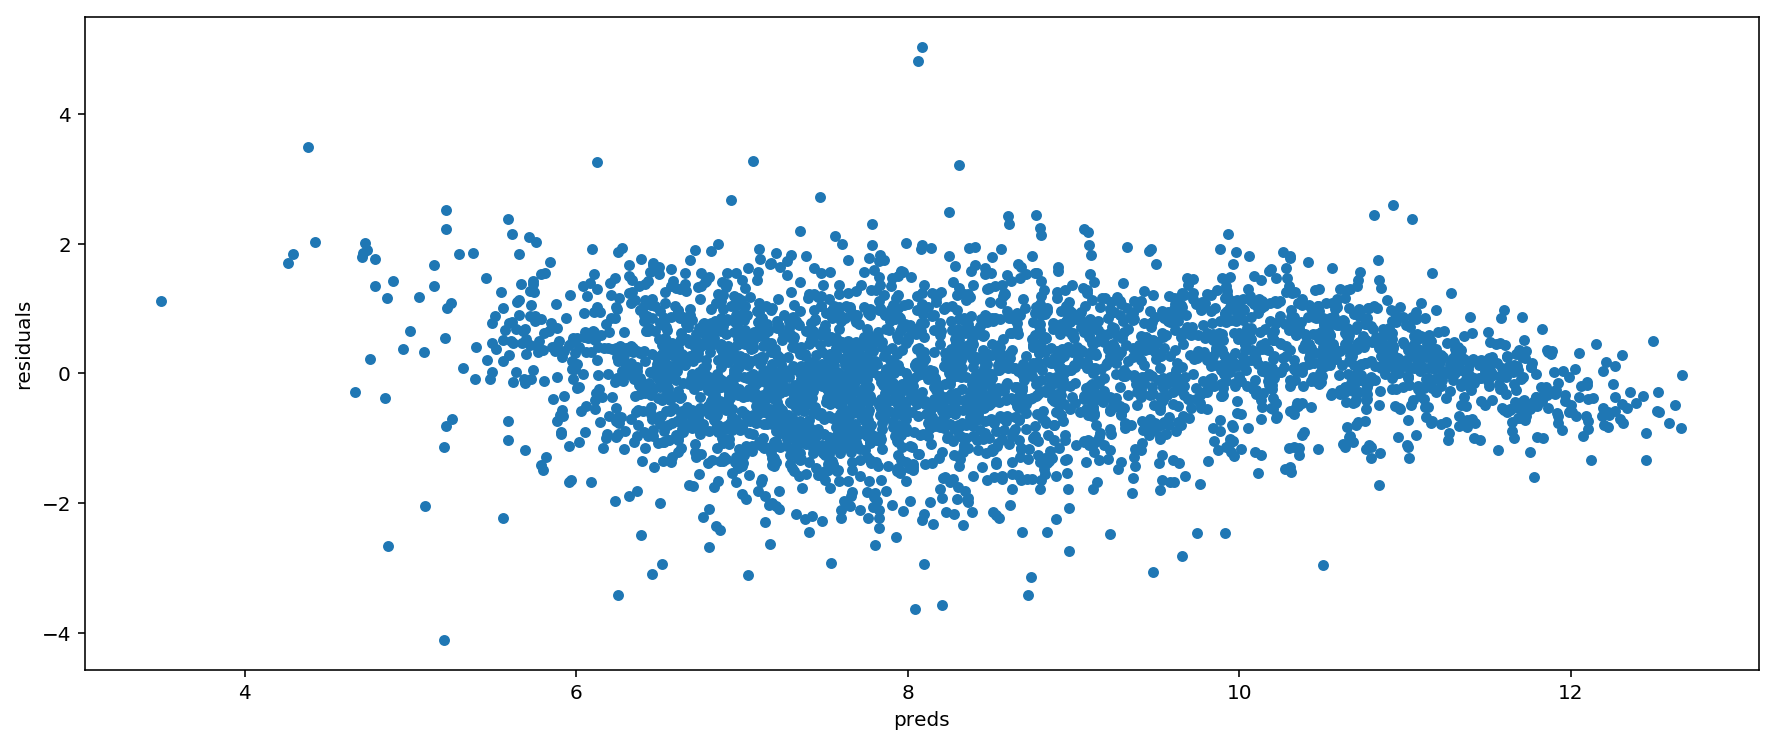

In [24]:
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Como podemos ver, não parece existir nenhum padrão nos resíduos.

### KNN
Agora vamos utilizar uma regressão não paramétrica, o KNN:

In [25]:
from sklearn.neighbors import KNeighborsRegressor

In [26]:
ks = [1, 2, 3, 5, 8, 13, 21, 25, 34, 41, 55]
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=k)).mean() 
            for k in ks]

Text(0,0.5,'rmse')

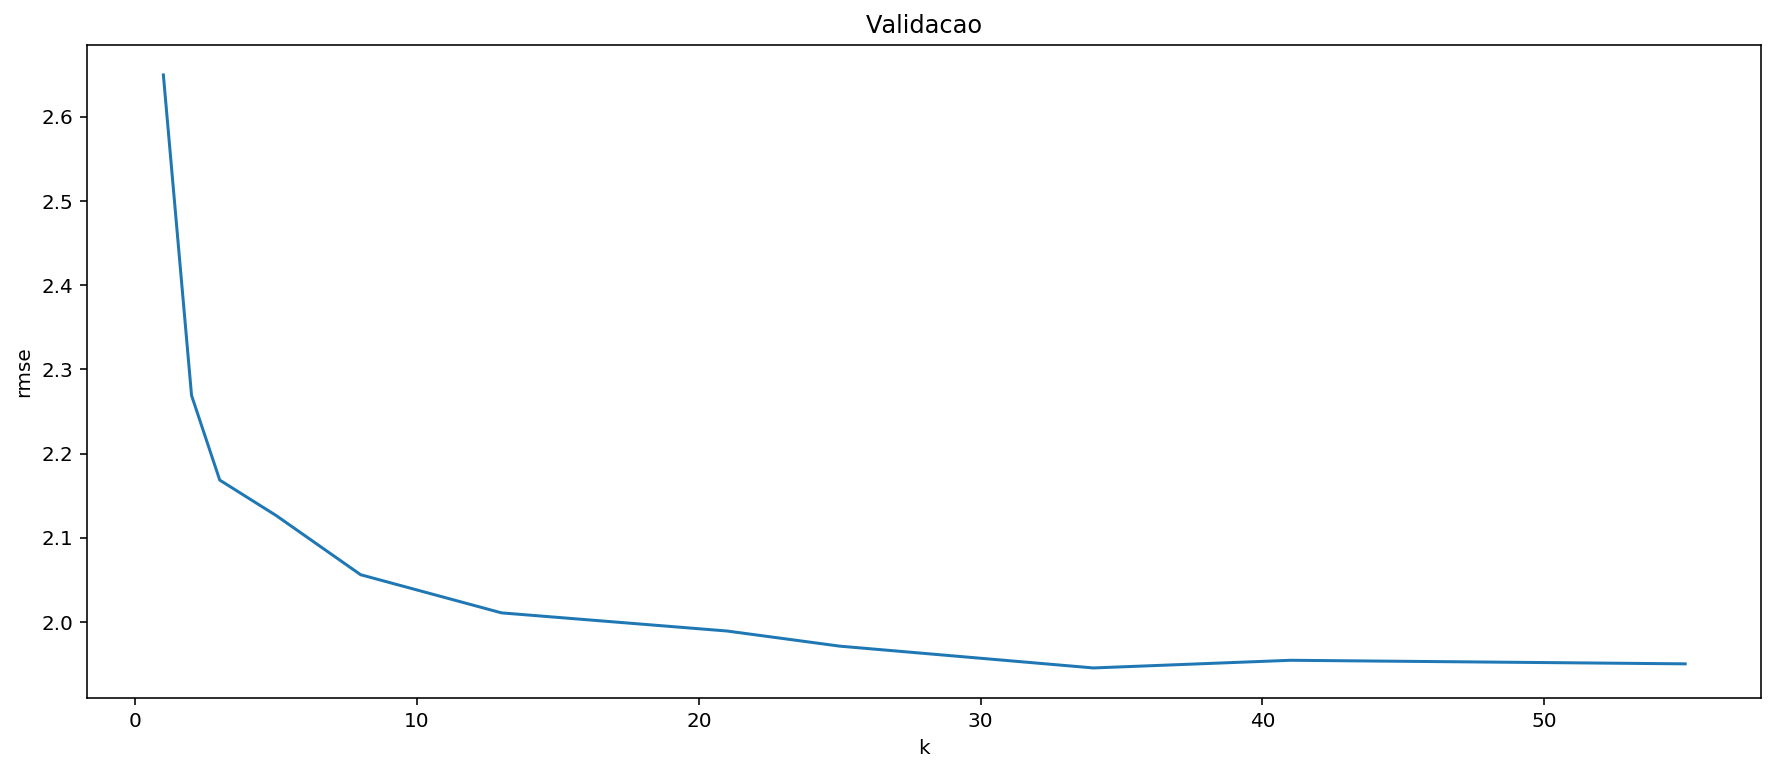

In [27]:
cv_knn = pd.Series(cv_knn, index = ks)
cv_knn.plot(title = "Validacao")
plt.xlabel("k")
plt.ylabel("rmse")

Vemos que o RMSE cai bastante ao longo das iterações, onde o seu mínimo é com k = 34.

Vejamos agora os resíduos do KNN:

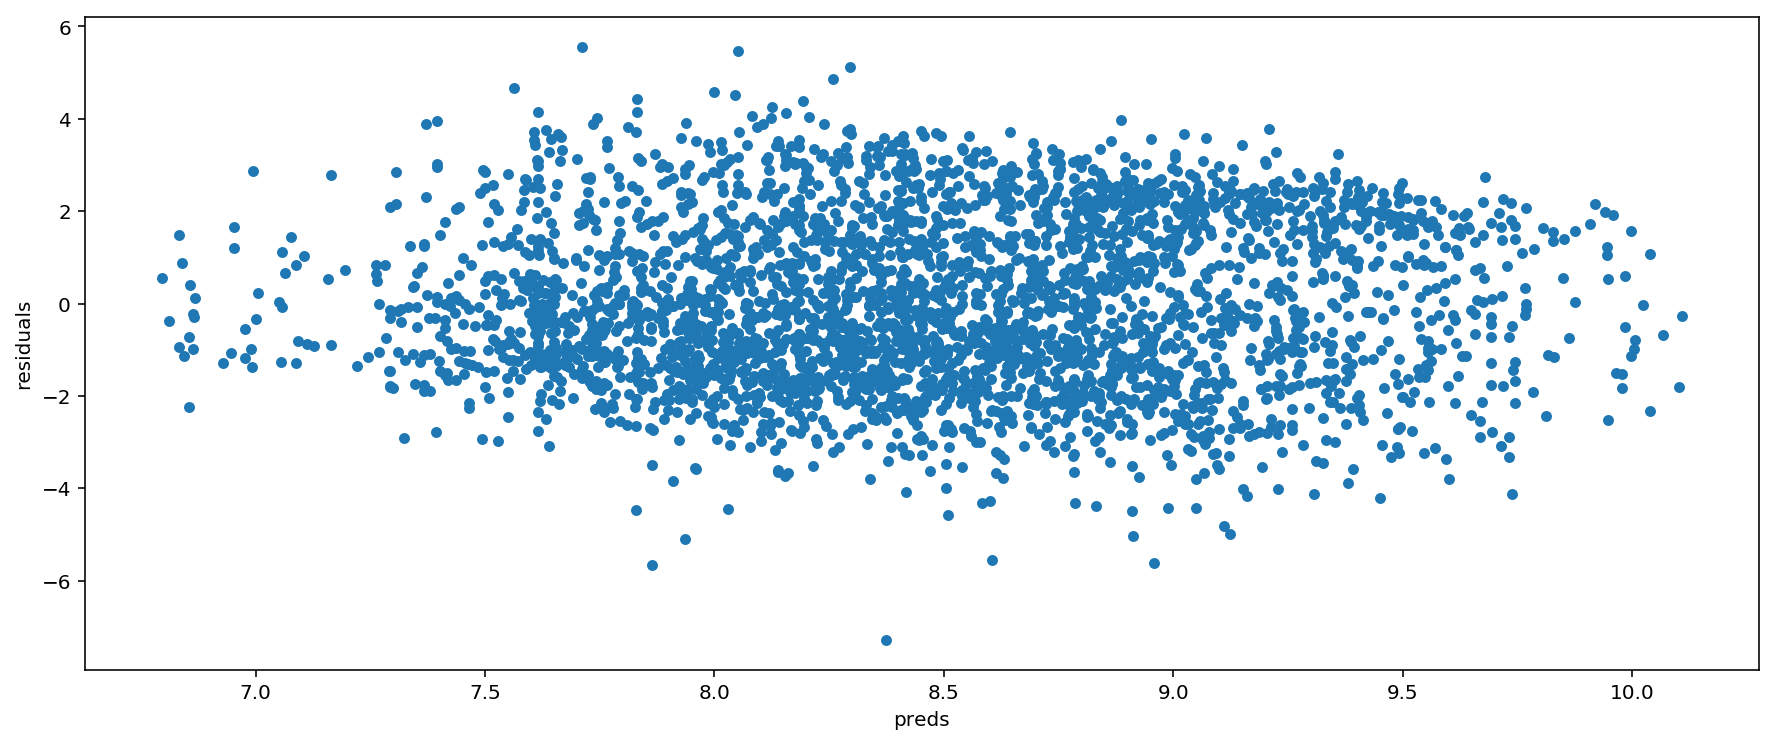

In [28]:
knn = KNeighborsRegressor(n_neighbors=34)
model_knn = knn.fit(X_train, y)

preds = pd.DataFrame({"preds":model_knn.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Novamente, os resíduos não parecem ter nenhum padrão.

### Random Forest
Vamos agora utilizar um método de regressão não linear, o random forest:

In [29]:
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [30]:
depth = [2, 3, 5, 8, 13, 21, 34, 55, 89, None]
cv_rf = [rmse_cv(RandomForestRegressor(max_depth=d, random_state=0, n_estimators=100)).mean() 
            for d in depth]

Text(0,0.5,'rmse')

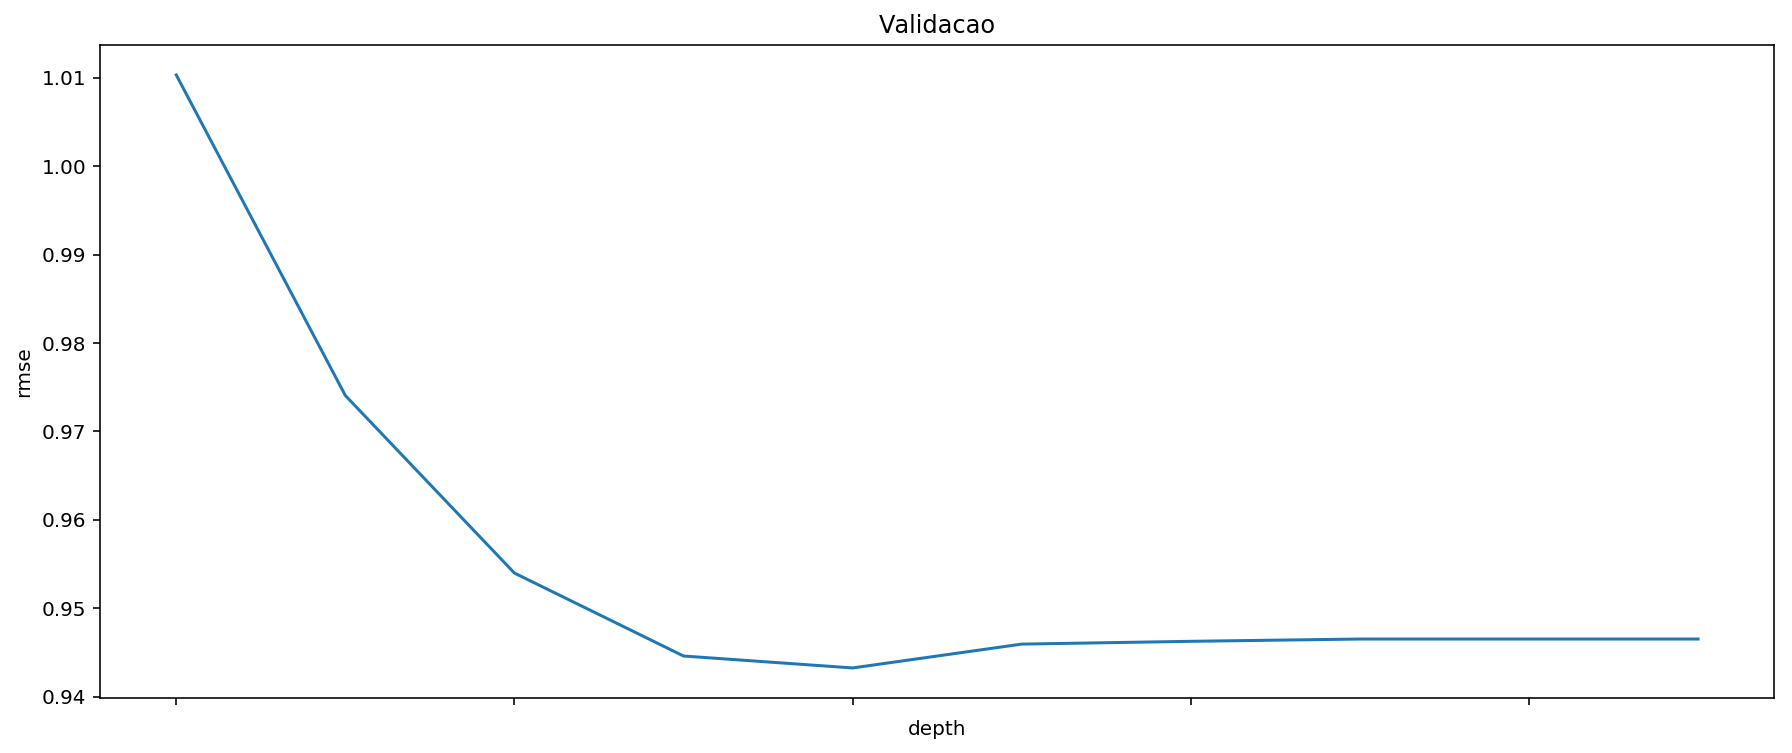

In [31]:
cv_rf = pd.Series(cv_rf, index = depth)
cv_rf.plot(title = "Validacao")
plt.xlabel("depth")
plt.ylabel("rmse")

Vemos que o RMSE cai bastante ao longo das iterações, onde o seu mínimo é com depth = 13.

Vejamos agora os resíduos do modelo com florestas aleatórias: 

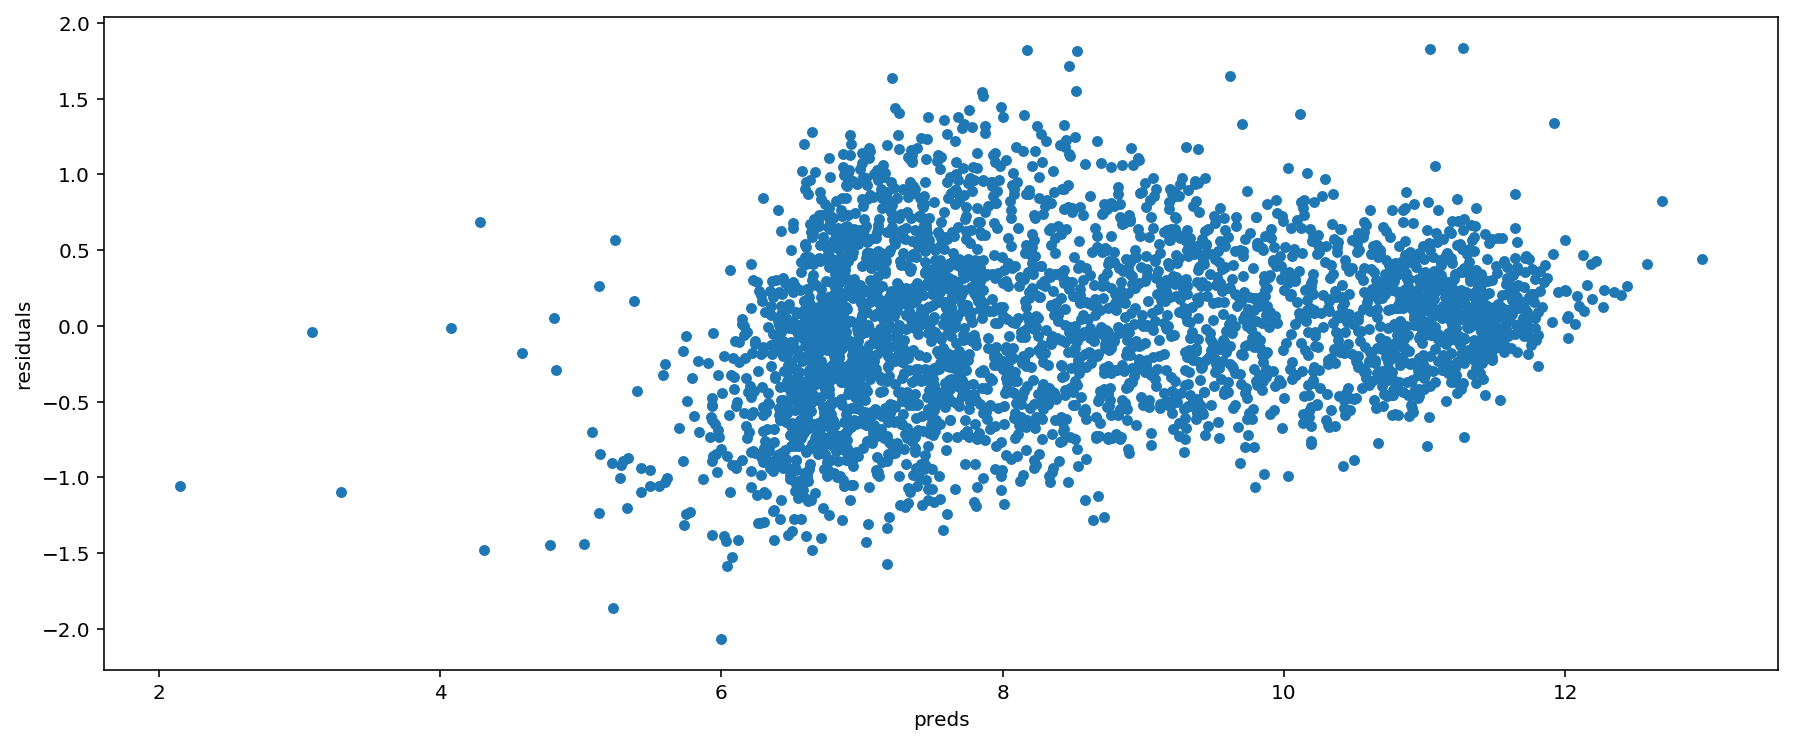

In [32]:
rf = RandomForestRegressor(max_depth=13, random_state=0, n_estimators=100)
model_rf = rf.fit(X_train, y)

preds = pd.DataFrame({"preds":model_rf.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Os resíduos parecem ter uma ligeira concentração de predições em valores mais altos, mas os resíduos parecem normalmente distribuídos se desconsiderarmos predições com valores mais baixos.

### Regressão Linear
Vamos comparar com um modelo mais simples, que utiliza apenas regressão linear:

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
rmse_cv(LinearRegression()).mean()

3031053.815484724

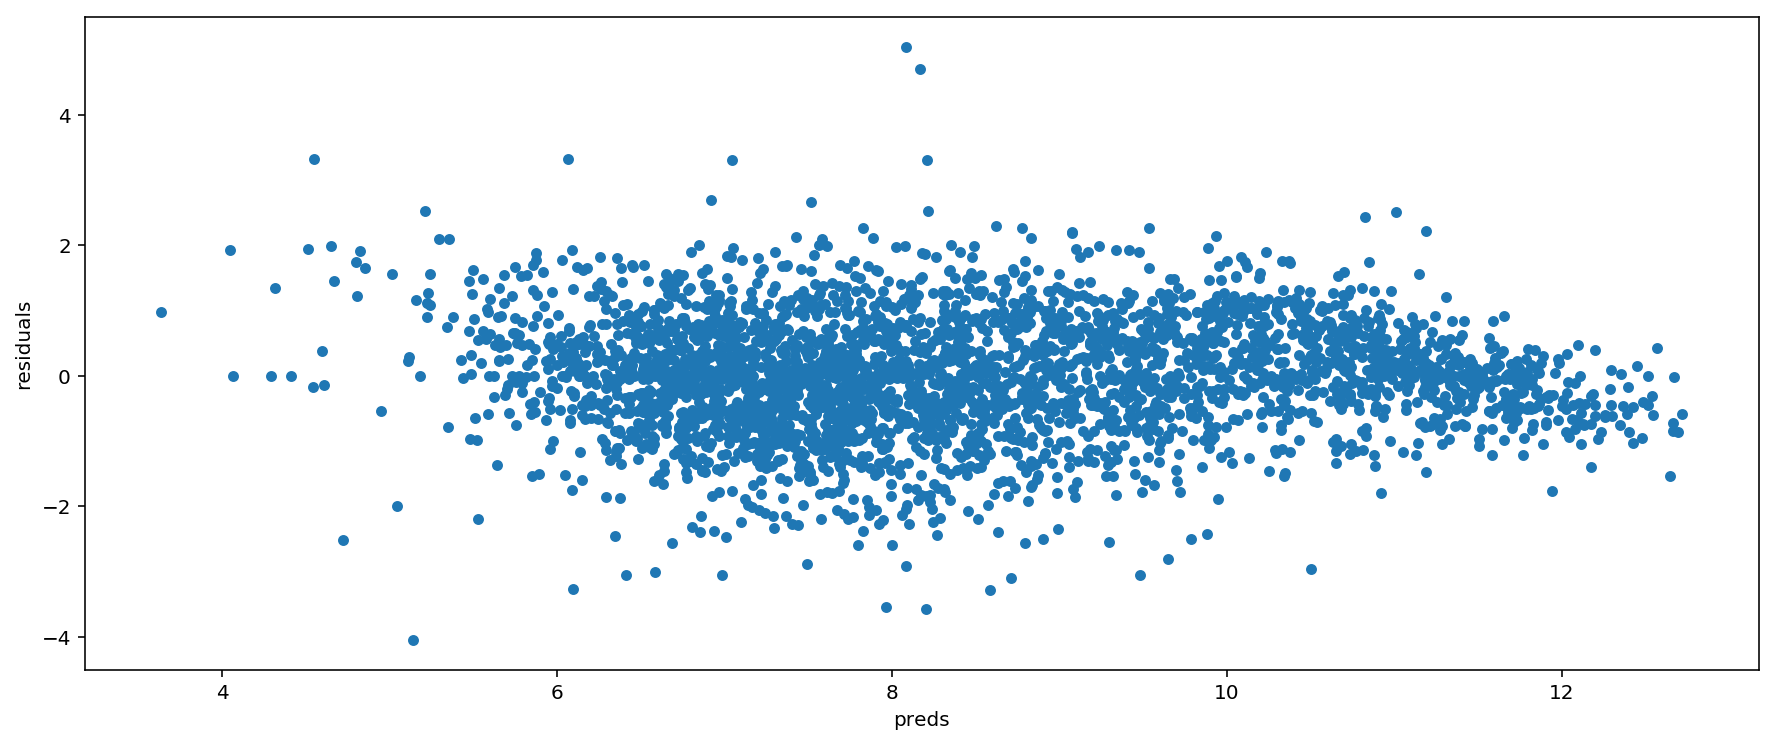

In [35]:
lr = LinearRegression()
model_lr = lr.fit(X_train, y)

preds = pd.DataFrame({"preds":model_lr.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Por algum motivo, apesar dos resíduos serem normalmente distribuídos, o RMSE médio é incrivelmente alto, sendo este 310326327271.04193.

## Teste com 2010
Vamos agora testar os dados de 2010 para ver como os modelos se comportam:

In [36]:
ridge_preds = model_ridge.predict(X_test.drop('votos', axis=1))
lasso_preds = model_lasso.predict(X_test.drop('votos', axis=1))
lr_preds = model_lr.predict(X_test.drop('votos', axis=1))
knn_preds = model_knn.predict(X_test.drop('votos', axis=1))
rf_preds = model_rf.predict(X_test.drop('votos', axis=1))

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

ridge_rmse = mean_squared_error(X_test.votos, ridge_preds) ** 0.5
ridge_r2 = r2_score(X_test.votos, ridge_preds)

lasso_rmse = mean_squared_error(X_test.votos, lasso_preds) ** 0.5
lasso_r2 = r2_score(X_test.votos, lasso_preds)

lr_rmse = mean_squared_error(X_test.votos, lr_preds) ** 0.5
lr_r2 = r2_score(X_test.votos, lr_preds)

knn_rmse = mean_squared_error(X_test.votos, knn_preds) ** 0.5
knn_r2 = r2_score(X_test.votos, knn_preds)

rf_rmse = mean_squared_error(X_test.votos, rf_preds) ** 0.5
rf_r2 = r2_score(X_test.votos, rf_preds)

print "ridge             - RMSE:%f           - Rsquared: %f" % (ridge_rmse, ridge_r2)
print "lasso             - RMSE:%f           - Rsquared: %f" % (lasso_rmse, lasso_r2)
print "linear regression - RMSE:%f - Rsquared: %f" % (lr_rmse, lr_r2)
print "knn               - RMSE:%f           - Rsquared: %f" % (knn_rmse, knn_r2)
print "random forest     - RMSE:%f           - Rsquared: %f" % (rf_rmse, rf_r2)

ridge             - RMSE:1.087846           - Rsquared: 0.712836
lasso             - RMSE:1.192708           - Rsquared: 0.654805
linear regression - RMSE:120226.741791 - Rsquared: -3507501955.169697
knn               - RMSE:2.108876           - Rsquared: -0.079190
random forest     - RMSE:0.988554           - Rsquared: 0.762865


Como podemos verificar, com os dados de teste de 2010, o menor rmse encontrado foi de 0.988554 obtido pelo modelo de florestas aleatórias e o mesmo modelo obteve melhor R², com valor de 0.76.

## Teste com 2014
Como último teste, vamos utilizar os dados vistos até então (2006 - 2010) como treino e novos dados (2014) como teste e ver se o melhor modelo encontrado permanece o de florestas aleatórias.

In [38]:
new_data = pd.read_csv("data/eleicoes_2014.csv")

Como os dados de treino e teste tem nomes das colunas diferentes vamos renomear o mais novo:

In [39]:
new_data = new_data.rename(index=str, columns={"sq_candidato": "sequencial_candidato",
                                    "nome_candidato": "nome",
                                    "sigla_uf": "uf",
                                    "sigla_partido": "partido",
                                    "qtd_doacoes": "quantidade_doacoes",
                                    "qtd_doadores": "quantidade_doadores",
                                    "recursos de outros candidatos/comitês": "recursos_de_outros_candidatos/comites",
                                    "recursos de pessoas físicas": "recursos_de_pessoas_fisicas",
                                    "recursos de pessoas jurídicas": "recursos_de_pessoas_juridicas",
                                    "recursos próprios": "recursos_proprios",
                                    "qtd_despesas": "quantidade_despesas",
                                    "qtd_fornecedores": "quantidade_fornecedores",
                                    "descricao_cargo": "cargo",
                                    "grau_instrucao": "grau",
                                    "descricao_ocupacao": "ocupacao"
                                   })

Agora vamos fazer as mesmas transformações feitas anteriormente nos dados, como correção de variáveis enviesadas, tratamento de valores ausentes, variáveis categóricas e normalização.

In [40]:
all_data = pd.concat([data, new_data], keys=["train", "test"])
all_data_transformed = all_data.drop(["sequencial_candidato", "nome", "cargo"], axis=1)

# Transforma variáveis enviesadas
numeric_feats = all_data_transformed.dtypes[all_data_transformed.dtypes != "object"].index
all_data_transformed[numeric_feats] = np.log1p(all_data_transformed[numeric_feats])

# Inputa dados faltantes
all_data_transformed = all_data_transformed.fillna(all_data_transformed.median())

# normaliza variáveis
numeric_feats = numeric_feats.drop("votos")
non_numeric_feats = all_data_transformed.dtypes[all_data_transformed.dtypes == "object"].index

min_max_scaler = preprocessing.MinMaxScaler()
all_data_normalized = min_max_scaler.fit_transform(all_data_transformed[numeric_feats])

all_data_normalized = pd.DataFrame(all_data_normalized, columns=all_data_transformed[numeric_feats].columns, 
                                   index=all_data_transformed.index)

all_data_normalized = all_data_normalized.assign(votos = all_data_transformed["votos"].values)

all_data_normalized = pd.concat([all_data_normalized, all_data_transformed[non_numeric_feats]], 
                                axis = 1, sort = False)

# Transforma variáveis categóricas em dummies
all_data_normalized = pd.get_dummies(all_data_normalized)

train = all_data_normalized.loc["train"]
test = all_data_normalized.loc["test"]

In [41]:
X_train = train.drop('votos', axis=1)
X_test = test
y = train.votos

In [42]:
model_ridge = Ridge(alpha=5.0).fit(X_train, y)
model_lasso = Lasso(alpha=0.001).fit(X_train, y)
model_lr = LinearRegression().fit(X_train, y)
model_knn = KNeighborsRegressor(n_neighbors=34).fit(X_train, y)
model_rf = RandomForestRegressor(max_depth=13, random_state=0, n_estimators=100).fit(X_train, y)

In [43]:
ridge_preds = model_ridge.predict(X_test.drop('votos', axis=1))
lasso_preds = model_lasso.predict(X_test.drop('votos', axis=1))
lr_preds = model_lr.predict(X_test.drop('votos', axis=1))
knn_preds = model_knn.predict(X_test.drop('votos', axis=1))
rf_preds = model_rf.predict(X_test.drop('votos', axis=1))

In [44]:
ridge_rmse = mean_squared_error(X_test.votos, ridge_preds) ** 0.5
ridge_r2 = r2_score(X_test.votos, ridge_preds)

lasso_rmse = mean_squared_error(X_test.votos, lasso_preds) ** 0.5
lasso_r2 = r2_score(X_test.votos, lasso_preds)

lr_rmse = mean_squared_error(X_test.votos, lr_preds) ** 0.5
lr_r2 = r2_score(X_test.votos, lr_preds)

knn_rmse = mean_squared_error(X_test.votos, knn_preds) ** 0.5
knn_r2 = r2_score(X_test.votos, knn_preds)

rf_rmse = mean_squared_error(X_test.votos, rf_preds) ** 0.5
rf_r2 = r2_score(X_test.votos, rf_preds)

print "ridge             - RMSE:%f           - Rsquared: %f" % (ridge_rmse, ridge_r2)
print "lasso             - RMSE:%f           - Rsquared: %f" % (lasso_rmse, lasso_r2)
print "linear regression - RMSE:%f - Rsquared: %f" % (lr_rmse, lr_r2)
print "knn               - RMSE:%f           - Rsquared: %f" % (knn_rmse, knn_r2)
print "random forest     - RMSE:%f           - Rsquared: %f" % (rf_rmse, rf_r2)

ridge             - RMSE:1.692625           - Rsquared: 0.561450
lasso             - RMSE:1.687853           - Rsquared: 0.563920
linear regression - RMSE:2384124354747.014648 - Rsquared: -870071683557566244192256.000000
knn               - RMSE:1.938584           - Rsquared: 0.424737
random forest     - RMSE:1.776520           - Rsquared: 0.516900


Como pode ser visto, os resultados se comportaram de maneira bem diferente de quando considerados apenas os anos de 2006 para treino e 2010 para teste. Antes o modelo que menos errava era o de florestas aleatórias, enquanto agora o melhor é a regressão com lasso.

Apesar da diferenças entre os erros dos modelos não serem tão grandes, como o lasso tem menor RMSE (1.687853) e maior R² (0.563920), além de ser um modelo relativamente simples, concluímos que ele é o melhor para prever dados de votos de deputados, considerando os dados vistos anteriormente.

Vejamos como o erro ficou a dispersão entre o valor real e o valor previsto:

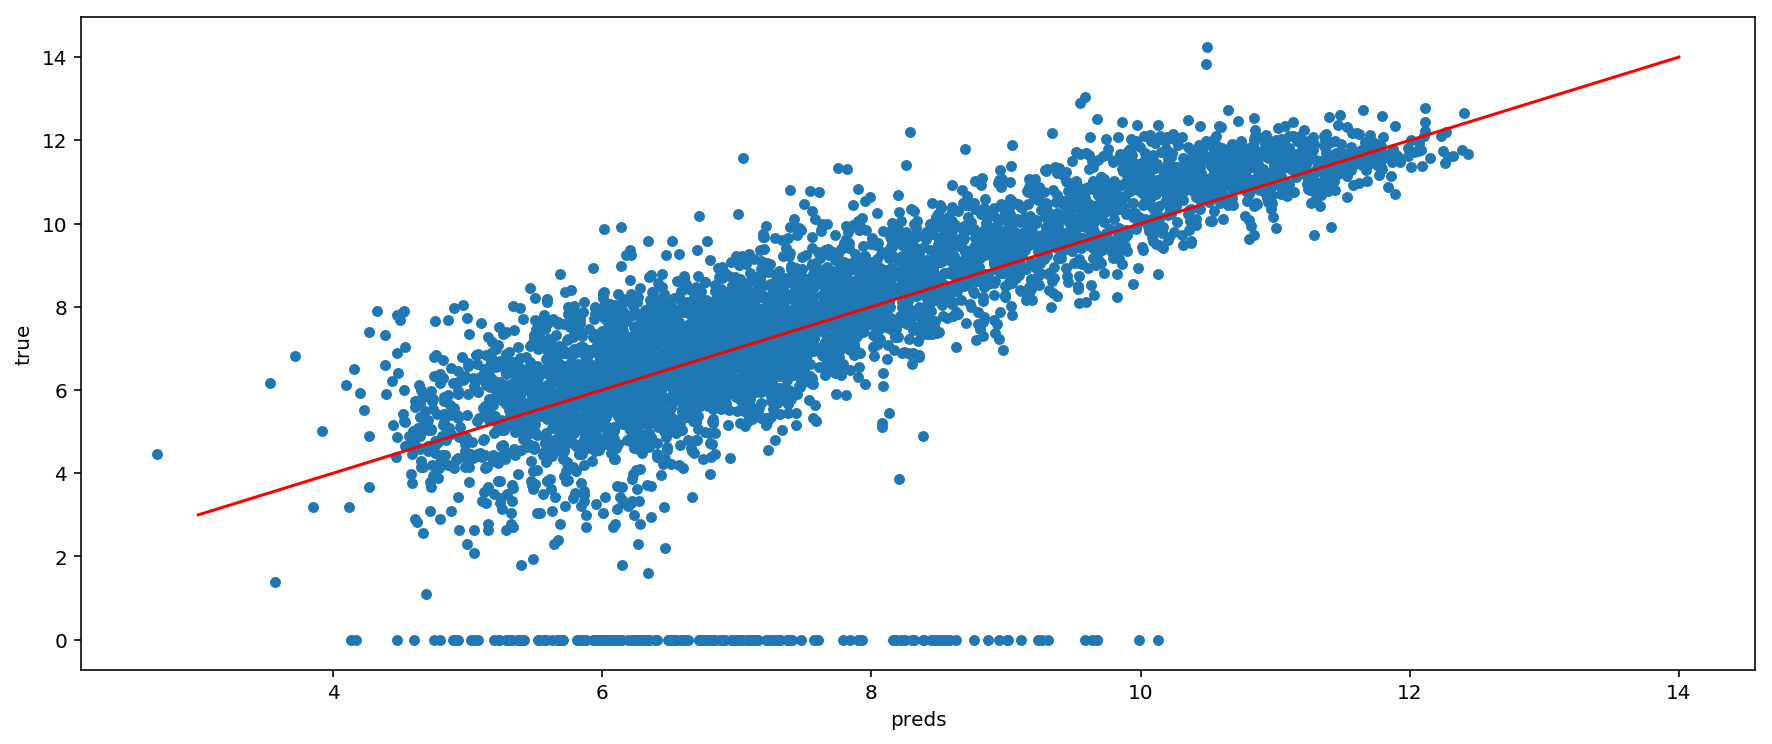

In [45]:
line = np.linspace(3, 14, 100)
x_line = np.linspace(3, 14, 100)

preds = pd.DataFrame({"preds": lasso_preds, "true":X_test.votos})
preds.plot(x = "preds", y = "true",kind = "scatter").plot(line, x_line, "red")

Vemos que o modelo prediz relativamente bem os dados, apesar de não conseguir identificar bem para quem teve zero votos.

Para entender melhor o quanto o modelo com lasso erra, vamos medir novamente o RMSE, porém com os dados de votos na escala normal:

In [46]:
print "RMSE: %f" % mean_squared_error(np.expm1(X_test.votos), np.expm1(lasso_preds)) ** 0.5
print "Média de votos: %f" % np.mean(np.expm1(X_test.votos))
print "Desvio padrão de votos: %f" % np.std(np.expm1(X_test.votos))

RMSE: 37465.615309
Média de votos: 17808.332253
Desvio padrão de votos: 46414.607713


Considerando que a média de votos dos deputados foi de cerca de 17,8 mil votos e o alto desvio padrão de 46,4 mil votos, um erro de cerca de 37,4 mil votos parece ser aceitável, tendo em vista que é um contexto com dados bastante dispersos.